# 2.5 Challenge Task: Quenching

In [1]:
#@title
# Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py


In [2]:
def make_system(T_init, mass, cP, T_init_env, vol_env, dens_env, cP_env, r, t_end,dt):
    tmass = mass * cP
    tmass_env = vol_env * dens_env * cP_env
    return dict(T_init=T_init, tmass=tmass,
                  T_init_env=T_init_env, tmass_env=tmass_env,
                  r=r,t_end=t_end,
                  t_0=0, dt=dt)

def make_state(system):
    state = pd.Series(dict(temp=system['T_init'], temp_env=system['T_init_env']))
    return state

In [3]:
def change_func(t, state, system):
    r, dt = system['r'], system['dt']
    deltaT = -r * (state.temp - state.temp_env) * dt
    Q = system['tmass']*deltaT
    deltaT_env = (-Q)/system['tmass_env']
    return deltaT, deltaT_env

In [4]:
def run_simulation(system, change_func):
    
    t_array = np.arange(system['t_0'], system['t_end']+1, system['dt'])
    n = len(t_array)
    state = make_state(system)
    results_T = pd.Series(index=t_array,dtype=object)
    results_T_env = pd.Series(index=t_array,dtype=object)
    results_T.iloc[0] = state.temp
    results_T_env.iloc[0] = state.temp_env
    
    for i in range(n-1):
        t = t_array[i]
        deltaT, deltaT_env = change_func(t, state, system)
        state.temp = state.temp + deltaT
        state.temp_env = state.temp_env + deltaT_env
        results_T.iloc[i+1] = state.temp
        results_T_env.iloc[i+1] = state.temp_env
    
    system['T_final'] = results_T.iloc[-1]
    system['T_final_env'] = results_T_env.iloc[-1]
    return results_T, results_T_env

100.08213250651984 41.18699533662842


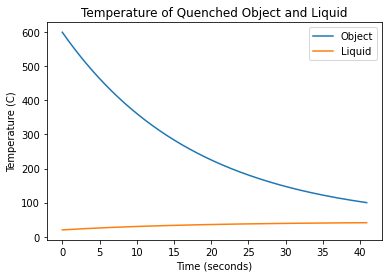

In [13]:
T_init = 600.0 # Temp of object, degrees C
mass   = 0.2 # mass of object, kg
cP     = 890 # specific heat of object, J/kgC
T_init_env = 20.0
vol_env = 0.001  # Volume of liquid, m3
dens_env = 1000
cP_env = 4200
r = 0.0535
t_end = 40 # End of simulation, seconds
dt = 0.1 # time step, seconds
system = make_system(T_init, mass,cP,T_init_env,vol_env,dens_env,cP_env,r, t_end,dt)
results_T, results_T_env = run_simulation(system,change_func)

results_T.plot(label='Object', xlabel='Time (seconds)',
         ylabel='Temperature (C)',
         title='Temperature of Quenched Object and Liquid',legend=True)
results_T_env.plot(legend=True,label='Liquid');
print(system['T_final'],system['T_final_env'])


In [11]:
def error_func(r, system):
    system['r'] = r
    results = run_simulation(system, change_func)
    return system['T_final'] - 100

In [12]:
import scipy.optimize as sp

system = make_system(T_init, mass,cP,T_init_env,vol_env,dens_env,cP_env,r, t_end,dt)
root_obj = sp.root_scalar(error_func, system, bracket=[0.1, 0.001])
root_obj

      converged: True
           flag: 'converged'
 function_calls: 11
     iterations: 10
           root: 0.05353393115810978